Quantum physics has changed our lives. Quantum computing and quantum communication
would impact many sectors, including biotechnology, chemistry industry, energy, finance,
security, etc. The race is underway. Investments to the quantum research and technology from
governments, research institutions, companies all around the world increasing rapidly, and
this leads to a rapid growth of the quantum computing market.

This project seeks to utilize Long-Short Term Memory (LSTM) model, to predict stock prices.
We use Keras to build a LSTM model to predict stock prices with historical opening, closing
prices and trading volume, and visualize and compare both the predicted price values over
time. We also compared the result of linear regression with LSTM.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.utils.vis_utils import plot_model

stocks = pd.read_csv('quantumstock1.csv')

The columns of the dataset are:

*  Date -- The date of the record.
*  Open -- The opening price of the day (when trading starts).
*  High -- The highest trade price during the day.
*  Low -- The lowest trade price during the day.
*  Close -- The closing price for the day (when trading is finished).
*  Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions.
*  Volume -- The number of shares traded.



data shape: (5190, 8)
            Date   open   high    low  close   adjclose      volume ticker
9592  2001-07-19  15.10  15.29  15.00  15.17  11.223610  34994300.0    ACN
9593  2001-07-20  15.05  15.05  14.80  15.01  11.105230   9238500.0    ACN
9594  2001-07-23  15.00  15.01  14.55  15.00  11.097830   7501000.0    ACN
9595  2001-07-24  14.95  14.97  14.70  14.86  10.994254   3537300.0    ACN
9596  2001-07-25  14.70  14.95  14.65  14.95  11.060840   4208100.0    ACN


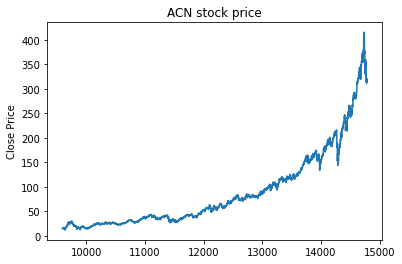

In [ ]:
#take ACN as an example
stock_data = stocks.loc[stocks['ticker'] == 'ACN']

#check raw data
print('data shape:', stock_data.shape)
print(stock_data.head())

#figure of ACN close price 
df = stock_data['close']
df = df.plot( title="ACN stock price")
df.set_ylabel("Close Price")

plt.show()

We normalize the dataset with MinMaxScaler function of sklearn library and split the dataset into training and testing sets with percentage of $90\%$ and $10\%$. The performance of our model is measured by root-mean-square deviation and mean absolute percentage error, which are given by equations below:


\begin{equation}
    RMSE = \sqrt{\sum_{i=1}^n \frac{(\hat{y}_i - y_i)^2}{n}}
\end{equation}

\begin{equation}
    MAPE = \frac{100\%}{n}\sum_{i=1}^n \mid \frac{(\hat{y}_i - y_i)^2}{y_i}\mid
\end{equation}

In [ ]:
#normalization
def normalize_data(data, features = ['open','close', 'volume']):
  scaler = MinMaxScaler()
  data = scaler.fit_transform(data[features])
  data = pd.DataFrame(data)
  data.columns = features
  return data


Stock price is time-series data as it is collected sequentially in time, and recorded in a specific time interval. Therefore, we apply linear regression to carry out the trend of  closing prices. 

However, linear regression with time series has a much flatter trend, and is unable to reflect the trend of the stock prices very well. In order to solve this problem, we carried out an improved linear regression algorithm by constructing Simple Moving Average (SMA). SMA, calculated by equation below, is the average price over a specified time period. We use a 30-day moving average as input to predict the close price.

\begin{equation}
    SMA = \frac{1}{n} \sum_{i=1}^n P_i
\end{equation}

In [ ]:
#split training set and test set for linear regression
def split_data_linear(input,output,test_size):
    split = int(math.floor(len(data) * test_size))
    X_train = input[:-split]
    X_test = input[-split:]

    y_train = output[:-split]
    y_test = output[-split:]
    return X_train,X_test,y_train,y_test


In [ ]:
#visualize
def plot_prediction(actual, prediction = 0, title='Actual vs Prediction', y_label='Price USD', x_label='Trading Days'):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.plot(actual, label='Actual Close')
    plt.plot(prediction,  label='Predicted Close')

    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()

X_train (4644, 1)
y_train (4644, 1)
X_test (516, 1)
y_test (516, 1)


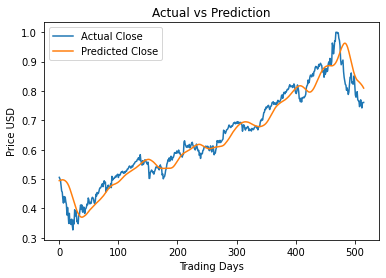

RMSE: 0.0401
MAPE: 0.0494


In [ ]:
data = normalize_data(stock_data)

# create date parameters(for time series model)
dates = pd.DataFrame(np.arange(len(data)))
data['dates'] = pd.DataFrame(np.arange(len(data)))

# create SMA parameters of 30 days(for SMA model)
data['day_30'] = data.close.rolling(30, win_type='triang').mean()
data = data[30:]
data.head()

#to build time series model, change features into ['date']
features = ['day_30']
target = ['close']

#split data set
X_train, X_test, y_train, y_test = split_data_linear(data[features], data[target],0.1)

#check the training set and test set
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)

#build linear model
model_linear = linear_model.LinearRegression()
model_linear.fit(X_train, y_train)

#prediction
predictions = model_linear.predict(X_test)
y_test = y_test.to_numpy().flatten()

#visualize
plot_prediction(y_test, predictions)

#accuray
rms = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)
print('RMSE: '+'%.4f' % rms)
print('MAPE: '+'%.4f' % mape)


To solve the problems in linear regression model, we implement LSTM model. First, we
dropped some variables, and only consider the opening, closing prices and volume as those
are the most important parameters. If we get a higher closing price than the opening price by
the end of day, we make profit, otherwise we lose money. The volume of share also matters, as
a rising volume indicate a rising market, while increasing stock price with a decreasing volume
shows lack of interest, and may imply a potential loss in the future.

 We pass the last
60 days of the data for training the model and output the predicted closing price. As we can
see from the figure, predicting done by LSTM performs a better fitting than LSTM with higher
accuracy  but there is still space for improvement.
In our model, we perform three ways to improve the LSTM model:


*   Add hidden layer: adding stacked multi-layers is for extracting more abstract information.

*   Add Dropout: adding dropout is a regular method to reduce overfitting and improving model performance.
*   Increase epochs: epochs is the times that the learning algorithm will work through the entire training  dataset. 

In [ ]:
#split training set and test set for LSTM
def split_data_lstm(data,test_size, step, prediction):
  tmp = test_size + step + 1

  X_train = data[0:-prediction - tmp].to_numpy()
  y_train = data[prediction : - tmp]['close'].to_numpy()
  X_test = data[0 - tmp : -prediction].to_numpy()
  y_test = data[prediction - tmp : ]['close'].to_numpy()

  return X_train,y_train,X_test,y_test

#change the shape
def reshape_data_lstm(data,step):
  res = []
  for i in range(len(data) - step):
    res.append(data[i : i + step])
  return np.asarray(res)

#build basic LSTM
def build_basic_model(input_dim, output_dim):
    model = Sequential()
    model.add(LSTM(input_shape=(None, input_dim),units=output_dim,return_sequences=False))
    model.add(LSTM(100,return_sequences=False))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    plot_model(model, show_shapes=True, show_layer_names=True)
    return model

#build improved LSTM
def build_model(input_dim, output_dim):
  model = Sequential()
  model.add(LSTM(input_shape = (None, input_dim),units = output_dim, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(128, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.add(Activation('linear'))
  plot_model(model, show_shapes=True, show_layer_names=True)
  return model

In [ ]:
data = normalize_data(stock_data)

#some parameters for LSTM
test_size = int (data.shape[0] / 10)
step = 60
prediction = 1

#split data set
X_train, y_train, X_test, y_test = split_data_lstm(data, test_size, step, prediction)
X_train = reshape_data_lstm(X_train, step)
X_test = reshape_data_lstm(X_test, step)
y_train = y_train[-X_train.shape[0]:]
y_test = y_test[-X_test.shape[0]:]

#check the training set and test set
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (4549, 60, 3)
y_train (4549,)
x_test (519, 60, 3)
y_test (519,)


In [ ]:
#change the model function name here
model = build_model(X_train.shape[-1],step)

#compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, batch_size=100,epochs=100,verbose=2,validation_split=0.05)


Epoch 1/100
43/43 - 20s - loss: 0.0023 - val_loss: 0.0012 - 20s/epoch - 459ms/step
Epoch 2/100
43/43 - 15s - loss: 1.6799e-04 - val_loss: 2.1403e-04 - 15s/epoch - 358ms/step
Epoch 3/100
43/43 - 15s - loss: 1.3569e-04 - val_loss: 1.6415e-04 - 15s/epoch - 358ms/step
Epoch 4/100
43/43 - 15s - loss: 1.1662e-04 - val_loss: 1.8091e-04 - 15s/epoch - 355ms/step
Epoch 5/100
43/43 - 15s - loss: 1.1412e-04 - val_loss: 1.6473e-04 - 15s/epoch - 355ms/step
Epoch 6/100
43/43 - 15s - loss: 1.1503e-04 - val_loss: 1.5399e-04 - 15s/epoch - 355ms/step
Epoch 7/100
43/43 - 16s - loss: 1.0548e-04 - val_loss: 2.8164e-04 - 16s/epoch - 361ms/step
Epoch 8/100
43/43 - 15s - loss: 1.0214e-04 - val_loss: 1.6097e-04 - 15s/epoch - 357ms/step
Epoch 9/100
43/43 - 15s - loss: 9.3445e-05 - val_loss: 1.7936e-04 - 15s/epoch - 357ms/step
Epoch 10/100
43/43 - 15s - loss: 1.0715e-04 - val_loss: 2.9724e-04 - 15s/epoch - 357ms/step
Epoch 11/100
43/43 - 15s - loss: 9.7195e-05 - val_loss: 1.9190e-04 - 15s/epoch - 357ms/step
Epoch

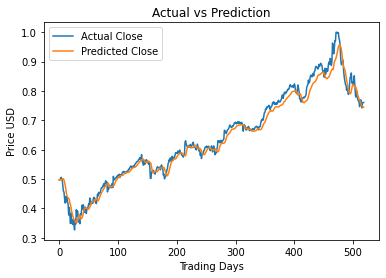

RMSE: 0.0229
MAPE: 0.0272


In [ ]:
#display
predictions_lstm = model.predict(X_test, batch_size=100)

plot_prediction(y_test,predictions_lstm)

rms = mean_squared_error(y_test, predictions_lstm, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions_lstm)
print('RMSE: '+'%.4f' % rms)
print('MAPE: '+'%.4f' % mape)
